In [24]:
import time
import pandas as pd
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from scipy import sparse
import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
pd.set_option('display.max_columns', 1000)
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns

C:\Users\nishant\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
with open("train.json","r") as c:
    data=json.load(c)

ingr=[]
cuis=[]
for obj in data:
    ingr.extend(obj['ingredients'])
    cuis.append(obj['cuisine'])
# for obj in data:
#     ingr.extend(obj['ingredients'])
#     cuis.append(obj['cuisine'])

ingr_uniq=list(set(ingr))
cuis_uniq=list(set(cuis))
ingr_uniq.sort()

In [3]:
len(ingr_uniq)

6714

In [4]:
len(cuis_uniq)

20

In [5]:
len(ingr)

428275

### wordcloud

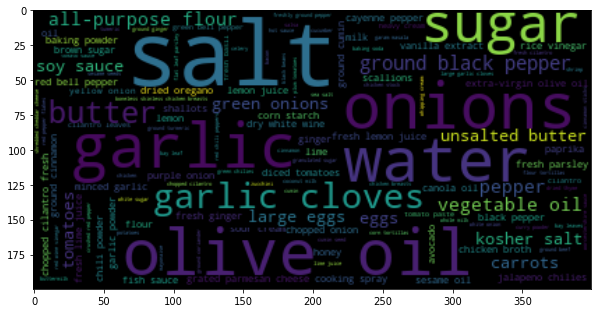

In [13]:
dd=pd.Series(ingr).value_counts().reset_index()
d = {}
for a, x in dd.values:
    d[a] = x


wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
plt.show()

### make cuisine by ingredient dataframe with frequency count 

empty_data=np.zeros((len(cuis_uniq),len(ingr_uniq)))
df=pd.DataFrame(empty_data, index=cuis_uniq, columns=ingr_uniq)

for obj in data:
    cuis_item=obj['cuisine']
    for ingredient_item in obj['ingredients']:
        df.loc[cuis_item,ingredient_item]+=1

### make recipes by ingredient dataframe 

In [84]:
start_time = time.time()
empty_data=np.zeros((len(data),len(ingr_uniq)))
df=pd.DataFrame(empty_data, index=[x['id'] for x in data], columns=ingr_uniq)

for obj in data:
    df.loc[obj['id'],obj['ingredients']]=1
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 45.259859800338745 seconds ---


### train test split

In [85]:
labels=[x['cuisine'] for x in data]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.15, random_state=42)

### logistic regression

In [90]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

print("train: ",clf.score(X_train,y_train))
print("test: ",clf.score(X_test,y_test))

C:\Users\nishant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train:  0.8890300383750166
test:  0.7893413775766717


### cleaning

In [8]:
len(ingr_uniq)

6714

In [9]:

data[285]


{'id': 45423,
 'cuisine': 'italian',
 'ingredients': ['(    oz.) tomato sauce',
  'ground veal',
  'sliced mushrooms',
  'italian seasoning mix',
  'finely chopped onion',
  'dry bread crumbs',
  'spaghetti',
  'beef',
  'diced tomatoes',
  'fresh basil leaves',
  'parmesan cheese',
  'large eggs',
  'fat skimmed chicken broth']}

In [11]:
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
import nltk 
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
# nltk.download('stopwords')

for obj in data:
    ing_clean=[]
    for ing in obj['ingredients']:
    #     tokens =word_tokenize(ing)

    #     print ([word for word in tokens if word.isalpha()])
        tokens = word_tokenize(ing)
        
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        
        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        
        # filter out stop words
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]

        tagged = nltk.pos_tag(words)
        words=[ele[0] for ele in tagged if ele[1] in ('NN','NNS')]

        porter = PorterStemmer()
#         stemmed = ' '.join([porter.stem(word) for word in words])

        stemmed=' '.join([ele[0] for ele in tagged if ele[1] in ('NN','NNS')])

        ing_clean.append(stemmed)
    

    obj['ingrdients_clean']=ing_clean

{'id': 45423,
 'cuisine': 'italian',
 'ingredients': ['(    oz.) tomato sauce',
  'ground veal',
  'sliced mushrooms',
  'italian seasoning mix',
  'finely chopped onion',
  'dry bread crumbs',
  'spaghetti',
  'beef',
  'diced tomatoes',
  'fresh basil leaves',
  'parmesan cheese',
  'large eggs',
  'fat skimmed chicken broth']}

In [14]:
ingr=[]
for obj in data:
    ingr.extend(obj['ingrdients_clean'])
ingr_uniq=list(set(ingr))

start_time = time.time()
empty_data=np.zeros((len(data),len(ingr_uniq)))
df=pd.DataFrame(empty_data, index=[x['id'] for x in data], columns=ingr_uniq)

for obj in data:
    df.loc[obj['id'],obj['ingrdients_clean']]=1
    
print("--- %s seconds ---" % (time.time() - start_time))


--- 22.845011234283447 seconds ---


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.15)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

print("train: ",clf.score(X_train,y_train))
print("test: ",clf.score(X_test,y_test))

C:\Users\nishant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nishant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


train:  0.8408613600733575
test:  0.7699011228422993


### doc2vec 

In [91]:
df=pd.DataFrame()
for i,obj in enumerate(data):
    df.loc[i,'ingr']=','.join(obj['ingredients'])
    df.loc[i,'cuisine']=obj['cuisine']

In [22]:
df.head()

,ingr,cuisine
0,"romaine lettuce,black olives,grape tomatoes,ga...",greek
1,"plain flour,ground pepper,salt,tomatoes,ground...",southern_us
2,"eggs,pepper,salt,mayonaise,cooking oil,green c...",filipino
3,"water,vegetable oil,wheat,salt",indian
4,"black pepper,shallots,cornflour,cayenne pepper...",indian


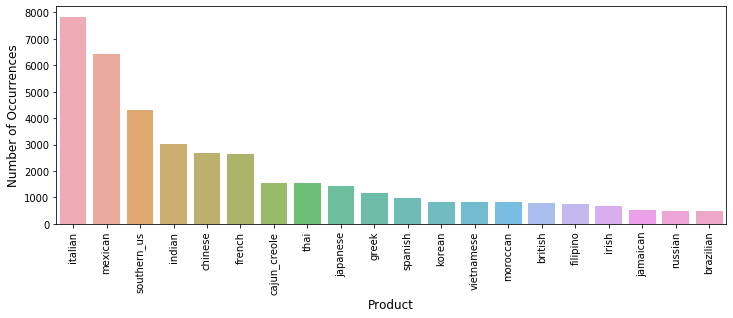

In [26]:
cnt_pro = df['cuisine'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [44]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['ingr'] = df['ingr'].apply(cleanText)

In [63]:
train, test = train_test_split(df, test_size=0.15, random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            
            if len(word) < 2:
                continue
            if word.isalpha()==0:
                continue
                
            tagged = nltk.pos_tag([word])
            if tagged[0][1] not in ('NN','NNS'):
                continue
        
            tokens.append(tagged[0][0].lower())
    return tokens
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['ingr']), tags=[r.cuisine]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['ingr']), tags=[r.cuisine]), axis=1)

In [65]:
#method1

import multiprocessing
cores = multiprocessing.cpu_count()

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors


y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [80]:
#method2

model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

# %%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

100%|████████████████████████████████████████████████████████████████████████████████████| 33807/33807 [00:00<?, ?it/s]


Testing accuracy 0.5213675213675214
Testing F1 score: 0.5058106341948725


C:\Users\nishant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [54]:
#combine method1 and method2

model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [81]:
df['ingr'].apply(lambda x: len(x.split(' '))).sum()

419326